# Домашнее задание 2

## Глубинное обучение в анализе графовых данных, ПМИ ВШЭ
Лузин Владимир Витальевич

В этом дз для мониторинга экспериментов лучше использовать сервис __wandb__, [здесь](https://docs.wandb.ai/quickstart) можете ознакомиться с документацией

### 1. PageRank Personalized (1 балл)

Реализуйте на основе кода с семинара персонализованный алгоритм PageRank с опцией возвращения в одну точку (индекс который подается в keep_updating_until_convergence(...)), либо же topic-related с возможностью вернуться в определенный массив точек (подается в эту же функцию). Подумайте над реализацией, опишите как вы решили модифицирвоать алгоритм, продемонстрируйте работспособность на каком-нибудь искуственном наборе данных (можно двудольном).

In [40]:
import networkx as nx
import numpy as np

Добавил по примеру кода из семинара 4
Решил добавить возможность вводить как одну вершину, так и массив точек (список)
Работает с несвязными компонентами.

In [93]:
def initialize_node_points(G):
    initial = {node: 1 / G.number_of_nodes() for node in G.nodes()}
    return G, initial

def update_node_points(G, previous_node_points, alpha=0.85, personalization=None):
    updated_node_points = {node: 0 for node in G.nodes()}
    
    nodes_num = G.number_of_nodes()
    if personalization is None: # Без телепортаций
        personalization = {node: 1 / nodes_num for node in G.nodes()}
    else: # С телепортацией
        personalization_sum = sum(personalization.values())
        personalization = {node: p / personalization_sum for node, p in personalization.items()}

    for node in G.nodes():
        node_references = list(G.out_edges(node))
        if len(node_references) == 0:
            for target in G.nodes(): # Распределение по персональным вершинам 
                updated_node_points[target] += previous_node_points[node] * personalization[target]
        else:
            share = alpha * previous_node_points[node] / len(node_references)
            for _, neighbor in node_references:
                updated_node_points[neighbor] += share

            # Добавляем вероятность перехода через "телепорт"
            for target in G.nodes():
                updated_node_points[target] += (1 - alpha) * personalization[target] * previous_node_points[node]

    return updated_node_points

def keep_updating_until_convergence(G, initial_node_points, alpha=0.85, personalization_nodes=None):
    convergence_value = 0.00001
    previous_node_points = initial_node_points

    personalization = {node: 0 for node in G.nodes()}
    if personalization_nodes is not None:
        if type(personalization_nodes) == int: # возвращение в одну точку
            personalization[personalization_nodes] = 1 
        elif type(personalization_nodes) == list: # topic-related
            for node in personalization_nodes:
                personalization[node] = 1 / len(personalization_nodes)

    iteration_counter = 0
    while True:
        updated_node_points = update_node_points(G, previous_node_points, alpha=alpha, personalization=personalization)
        
        # Проверяем сходимость
        if all(abs(updated_node_points[node] - previous_node_points[node]) < convergence_value for node in G.nodes()):
            return updated_node_points, iteration_counter
        
        # Не сошлось? Продолжаем
        previous_node_points = updated_node_points
        iteration_counter += 1


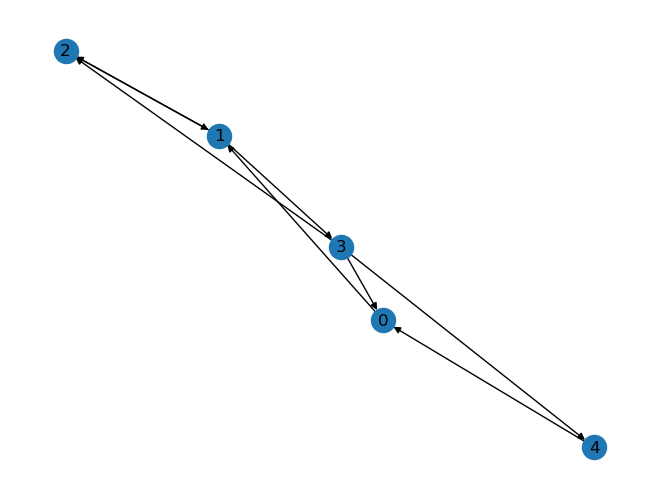

In [94]:
G = nx.DiGraph()
nodes = [i for i in range(0, 5)]
edges = [(0,1), (1,2), (1,3), (2,1), (3,0), (3,2), (3,4), (4,0)]
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

In [97]:
G, initial_node_points = initialize_node_points(G)
pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points, alpha=0.5, personalization_nodes=0)

print("Телепорт в нулевую вершину")
print('Iteration counter:', iteration_counter)
print('Pageranks:', pageranks)


pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points, alpha=0.5, personalization_nodes=[1, 4])

print("две вершины")
print('Iteration counter:', iteration_counter)
print('Pageranks:', pageranks)



Телепорт в нулевую вершину
Iteration counter: 9
Pageranks: {0: 0.5189863793643903, 1: 0.3037993254484953, 2: 0.0886071475935571, 3: 0.07594762731481482, 4: 0.012659520278742281}
две вершины
Iteration counter: 9
Pageranks: {0: 0.14873468846450616, 1: 0.37974514431423617, 2: 0.11076008361062886, 3: 0.09493803801359954, 4: 0.2658220455970293}


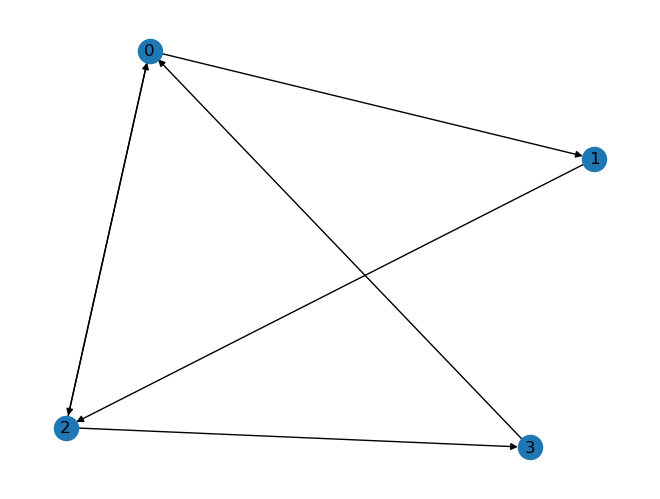

In [98]:
G = nx.DiGraph()
edges = [(0, 1), (0, 2), (1, 2), (2, 0), (2, 3), (3, 0)]
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

In [99]:
G, initial_node_points = initialize_node_points(G)
pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points, alpha=0.5,
                                                               personalization_nodes=0)

print("Телепорт в нулевую вершину")
print('Iteration counter:', iteration_counter)
print('Pageranks:', pageranks)

pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points, alpha=0.5,
                                                               personalization_nodes=[1, 2])

print("две вершины")
print('Iteration counter:', iteration_counter)
print('Pageranks:', pageranks)



Телепорт в нулевую вершину
Iteration counter: 10
Pageranks: {0: 0.5818206667900085, 1: 0.14545375108718872, 2: 0.21817940473556519, 3: 0.05454617738723755}
две вершины
Iteration counter: 10
Pageranks: {0: 0.16363590955734253, 1: 0.2909103035926819, 2: 0.4363641142845154, 3: 0.1090896725654602}


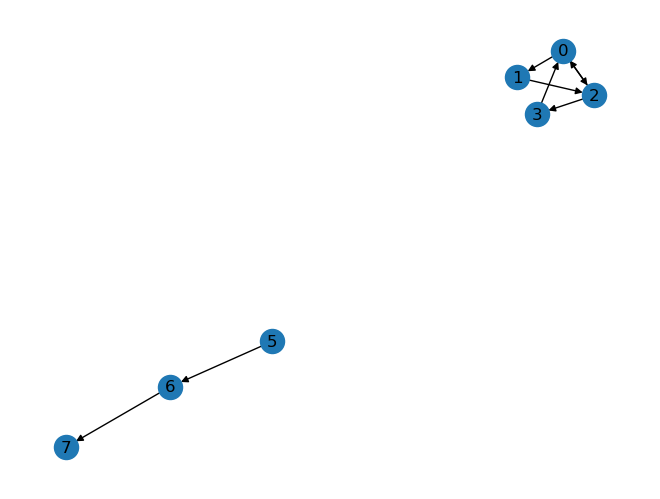

In [100]:
# Проверю на двух несвязанных графах.

G = nx.DiGraph()
edges = [(0, 1), (0, 2), (1, 2), (2, 0), (2, 3), (3, 0), (5, 6), (6, 7)]
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

In [101]:
# Здесь должны быть большие значения у вершин 5, 6, 7
G, initial_node_points = initialize_node_points(G)
pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points, alpha=0.8,personalization_nodes=5)

print("Телепорт в вершину 5")
print('Iteration counter:', iteration_counter)
print('Pageranks:', pageranks)

# Здесь должны быть большие значения у остальных вершин
pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points, alpha=0.5,personalization_nodes=2)

print("Телепорт в вершину 2")
print('Iteration counter:', iteration_counter)
print('Pageranks:', pageranks)

# Телепорты в обе вершины позволяют попадать во все вершины. Теперь всё выглядит хорошо.
pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points, alpha=0.5,personalization_nodes=[2,5])

print("Телепорт в вершину 2")
print('Iteration counter:', iteration_counter)
print('Pageranks:', pageranks)

Телепорт в вершину 5
Iteration counter: 44
Pageranks: {0: 8.296408183977253e-06, 1: 4.1482040919885375e-06, 2: 8.296408183977253e-06, 3: 4.1482040919885375e-06, 5: 0.40982443700164384, 6: 0.32786079406254265, 7: 0.2622898797112618}
Телепорт в вершину 2
Iteration counter: 10
Pageranks: {0: 0.21818021365574422, 1: 0.054546526500156935, 2: 0.5818199089595248, 3: 0.14545335088457376, 5: 0.0, 6: 0.0, 7: 0.0}
Телепорт в вершину 2
Iteration counter: 11
Pageranks: {0: 0.11636656522750854, 1: 0.029090140547071184, 2: 0.31030003513608656, 3: 0.07757717370986938, 5: 0.2666647774832589, 6: 0.13333347865513392, 7: 0.06666782924107142}


### Реализация слоев графовых нейронных сетей для классификации вершин

На 5ом семинаре мы реализовали слой **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)). Здесь вы должны реализовать еще более мощные слои: **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) и **GCN** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)). Затем вы должны запустить модели для решения задачи классификации вершин на наборе данных CORA.

In [ ]:
# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install torch-geometric

Ниже приведен общий модуль GNN, куда можно добавить любой реализованный слой GNN

In [18]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

In [19]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GCN':
            return GCNConv
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)


In [20]:
class GraphSage(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize=True,
                 bias=False, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size=None):
        # x is shape (N, in_c)
        neighbor_out = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(neighbor_out)
        if self.normalize:
            out = torch.nn.functional.normalize(out, p=2)

        return out

    def message(self, x_j):
        # x_j has shape (E, d)
        out = x_j
        return out

    def aggregate(self, inputs, index, dim_size=None):
        node_dim = self.node_dim

        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')

        return out

### GCN (3 балла)

Слой GCN математически определяется как
$$\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{W}^{\top} \cdot \mathbf{x}_j^{(k-1)} \right) + \mathbf{b},$$

где признаки соседних узлов сначала преобразуются матрицей весов $W$, нормализуются по их степени и суммируются. Наконец, мы применяем вектор смещения $b$ к агрегированному результату. Эту формулу можно разделить на следующие шаги:

1. Добавить петли в матрицу смежности (можно использовать функцию add_self_loops из torch_geometric).
2. Линейное преобразование матрицу призанков вершин.
3. Вычисление коэффициентов нормализации.
4. Нормирование призанаков вершин.
5. Суммирование признаков соседних вершин (агрегация «add»).
6. Применение вектора смещения.

Шаги 1-3 обычно вычисляются до передачи сообщения. Шаги 4-5 можно легко выполнить с помощью базового класса MessagePassing. Ниже вам нужно реализовать методы *message* и *forward* на основе message passing

In [1]:
import torch
import torch_geometric
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x=x, norm=norm) + self.bias


    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

### GAT (6 баллов)

Ниже вам нужно реализовать методы *message*, *forward* и *aggregate* для Graph Attention Network слоя на основе message passing

In [2]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)

        self.lin_r = self.lin_l

        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        H, C = self.heads, self.out_channels

        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)

        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r

        return self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size).reshape(-1, H*C)

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        if ptr:
            att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
            att_weight = torch_geometric.utils.softmax(alpha_i + alpha_j, index)

        return F.dropout(att_weight, p=self.dropout) * x_j

    def aggregate(self, inputs, index, dim_size = None):
        return torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce='sum')

Ниже код для тестирования GNN слоев

In [3]:
import torch.optim as optim


def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler is None:
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [4]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                     args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)
        wandb.log({"loss": total_loss}) # wandb

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            test_accs.append(test_acc)
            wandb.log({"accuracy": test_acc})
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = copy.deepcopy(model)# wandb
        else:
            test_accs.append(test_accs[-1])
            wandb.log({"accuracy": test_accs[-1]})# wandb

    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
            print ("Saving Model Predictions for Model Type", model_type)

            data = {}
            data['pred'] = pred.view(-1).cpu().detach().numpy()
            data['label'] = label.view(-1).cpu().detach().numpy()

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total

class ObjectView(object):
    def __init__(self, d):
        self.__dict__ = d


Настройте аргументы и запустите функции train и test на разных блоках (*GraphSAGE* с семинара, *GCN*, *GAT*) на датасете Cora и на любом другом на выбор из доступных в библиотеке torch_geometric и сравните полученное качество на разных слоях.

In [5]:
import wandb

wandb.login()

wandb: Currently logged in as: vldmrl (vldmrl-org). Use `wandb login --relogin` to force relogin


True

GraphSage

In [29]:
run = wandb.init(
    project="gnn-hw2",
    name="GraphSage"
)

In [30]:
args = ObjectView({
    'model_type': 'GraphSage',
    'dataset': 'cora',
    'num_layers': 2,
    'heads': 1,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.3,
    'epochs': 500,
    'opt': 'adam',
    'opt_scheduler': None,
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'lr': 0.01
})

/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:29<00:00, 17.08Epochs/s]


Maximum test set accuracy: 0.796
Minimum loss: 0.050411712378263474
Saving Model Predictions for Model Type GraphSage


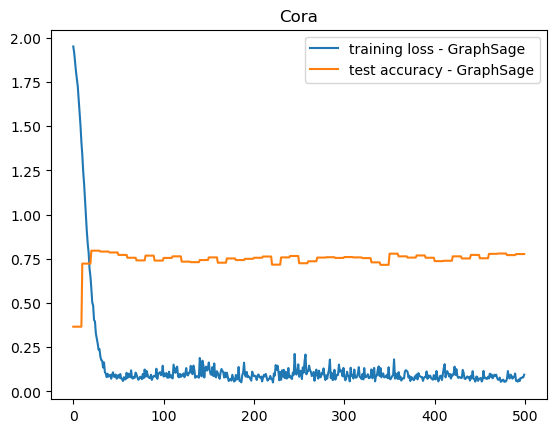

In [31]:
model = 'GraphSage'
if args.dataset == 'cora':
    dataset = Planetoid(root='/tmp/cora', name='Cora')
else:
    raise NotImplementedError("Unknown dataset")

test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# Run test for our best model to save the predictions!
test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
print()

plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - " + args.model_type)
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()
plt.show()

In [32]:
wandb.finish()

accuracy,▁▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇█▇▇▇▇█▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.777
loss,0.09457


GCN

In [33]:
run = wandb.init(
    project="gnn-hw2",
    name="GCN"
)

In [34]:
args = ObjectView({
    'model_type': 'GCN',
    'dataset': 'cora',
    'num_layers': 2,
    'heads': 1,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.3,
    'epochs': 500,
    'opt': 'adam',
    'opt_scheduler': None,
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'lr': 0.01
})

/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:08<00:00, 62.00Epochs/s]


Maximum test set accuracy: 0.8
Minimum loss: 0.02075481042265892
Saving Model Predictions for Model Type GCN


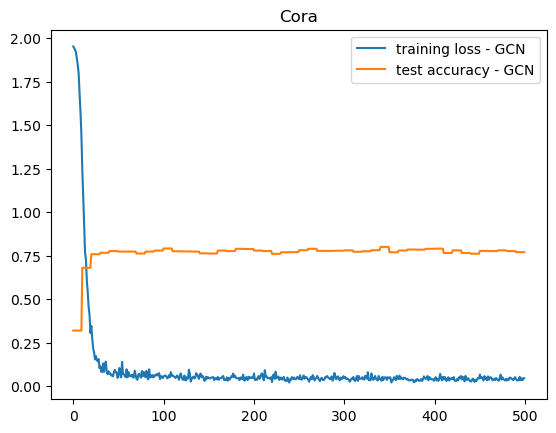

In [35]:
model = 'GCN'

if args.dataset == 'cora':
    dataset = Planetoid(root='/tmp/cora', name='Cora')
else:
    raise NotImplementedError("Unknown dataset")

test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# Run test for our best model to save the predictions!
test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
print()

plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - " + args.model_type)
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()
plt.show()

In [36]:
wandb.finish()

accuracy,▁▆▇███▇█████▇████████████████████▇▇▇████
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.77
loss,0.04533


GAT

In [37]:
run = wandb.init(
    project="gnn-hw2",
    name="GAT"
)

In [38]:
args = ObjectView({
    'model_type': 'GAT',
    'dataset': 'cora',
    'num_layers': 2,
    'heads': 2,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.3,
    'epochs': 500,
    'opt': 'adam',
    'opt_scheduler': None,
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'lr': 0.01
})

/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:22<00:00, 21.81Epochs/s]


Maximum test set accuracy: 0.786
Minimum loss: 0.01579977571964264
Saving Model Predictions for Model Type GAT


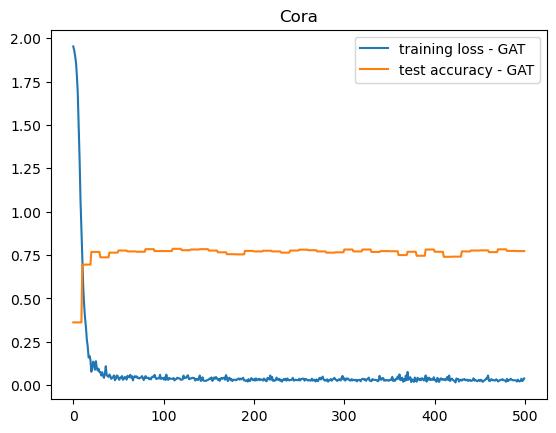

In [39]:
model = 'GAT'
if args.dataset == 'cora':
    dataset = Planetoid(root='/tmp/cora', name='Cora')
else:
    raise NotImplementedError("Unknown dataset")

test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# Run test for our best model to save the predictions!
test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
print()

plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - " + args.model_type)
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()

In [40]:
wandb.finish()

accuracy,▁▆█▇██████████▇███████████████▇██▇██████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.773
loss,0.03937


Также поэксперементируйте с параметрами сетей и на основе экспериментов ниже напишите выводы.

Скорее всего достаточно оставить эксперименты в wandb, но на всякий случай не буду удалять код.

In [6]:
args = ObjectView({
    'model_type': 'GraphSage',
    'dataset': 'cora',
    'num_layers': 2,
    'heads': 1,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.3,
    'epochs': 500,
    'opt': 'adam',
    'opt_scheduler': None,
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'lr': 0.01
})

In [23]:
def experiment(test_name: str) -> None:
    '''
    Функция для проведения экспериментов
    Вне функции меняются аргументы, которые внутри функции прогонаются через все 3 модели
    Логи сохраняются в wandb.
    '''
    
    
    # GraphSage
    run = wandb.init(
        project="gnn-hw2",
        name="GraphSage_" + test_name,
    )

    args.model_type = 'GraphSage'
    args.heads = 1
    if args.dataset == 'cora':
        dataset = Planetoid(root='/tmp/cora', name='Cora')
    else:
        raise NotImplementedError("Unknown dataset")

    test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

    print('GraphSage')
    print("Maximum test set accuracy: {0}".format(max(test_accs)))
    print("Minimum loss: {0}".format(min(losses)))

    test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=args.model_type)
    print()

    wandb.finish(quiet=True)

    # GCN
    run = wandb.init(
        project="gnn-hw2",
        name="GCN_" + test_name,
    )

    args.model_type = 'GCN'
    args.heads = 1

    if args.dataset == 'cora':
        dataset = Planetoid(root='/tmp/cora', name='Cora')
    else:
        raise NotImplementedError("Unknown dataset")

    test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

    print('GCN')
    print("Maximum test set accuracy: {0}".format(max(test_accs)))
    print("Minimum loss: {0}".format(min(losses)))

    test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=args.model_type)
    print()

    wandb.finish()

    # GAT
    run = wandb.init(
        project="gnn-hw2",
        name="GAT_" + test_name,
    )

    args.model_type = 'GAT'
    args.heads = 2

    if args.dataset == 'cora':
        dataset = Planetoid(root='/tmp/cora', name='Cora')
    else:
        raise NotImplementedError("Unknown dataset")

    test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)
    print('GAT')

    print("Maximum test set accuracy: {0}".format(max(test_accs)))
    print("Minimum loss: {0}".format(min(losses)))

    # Run test for our best model to save the predictions!
    test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=args.model_type)
    print()
    
    wandb.finish()

Увеличу количество слоёв с 2 до 3

In [24]:
args.num_layers = 3

In [26]:
experiment("3_layers")

/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:25<00:00, 19.99Epochs/s]


GraphSage
Maximum test set accuracy: 0.795
Minimum loss: 0.054214052855968475
Saving Model Predictions for Model Type GraphSage


/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:07<00:00, 67.63Epochs/s]


GCN
Maximum test set accuracy: 0.734
Minimum loss: 0.027765221893787384
Saving Model Predictions for Model Type GCN


accuracy,▁▄▄▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇██▇██████▇▇█████
loss,██▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.722
loss,0.06213


/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:24<00:00, 20.23Epochs/s]


GAT
Maximum test set accuracy: 0.793
Minimum loss: 0.012981902807950974
Saving Model Predictions for Model Type GAT


accuracy,▁▆█████████▇███▇███████▇▇▇████████▇█████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.748
loss,0.01519


In [27]:
args.num_layers = 2

Уменьшу длину шага до 0.001, так как модель на вид обучается слишком быстро

In [28]:
args.lr = 0.001

In [29]:
experiment("lr_0-001")

/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:22<00:00, 22.28Epochs/s]


GraphSage
Maximum test set accuracy: 0.763
Minimum loss: 0.06755867600440979
Saving Model Predictions for Model Type GraphSage


/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:06<00:00, 77.37Epochs/s]


GCN
Maximum test set accuracy: 0.806
Minimum loss: 0.036746829748153687
Saving Model Predictions for Model Type GCN


accuracy,▁▁▂▄▅▆▇█████████████████████████████████
loss,███▇▆▅▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.799
loss,0.0544


/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:19<00:00, 26.11Epochs/s]


GAT
Maximum test set accuracy: 0.791
Minimum loss: 0.02483396604657173
Saving Model Predictions for Model Type GAT


accuracy,▁▁▂▅▅▆██████████████████████████████████
loss,███▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.773
loss,0.04268


In [31]:
args.lr = 0.01

Добавлю щедулер

In [32]:
args.opt_scheduler = 'cos'

In [33]:
experiment("scheduler_cos")

/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:24<00:00, 20.63Epochs/s]


GraphSage
Maximum test set accuracy: 0.779
Minimum loss: 0.0552455298602581
Saving Model Predictions for Model Type GraphSage


/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:06<00:00, 78.84Epochs/s]


GCN
Maximum test set accuracy: 0.782
Minimum loss: 0.025254353880882263
Saving Model Predictions for Model Type GCN


accuracy,▁▆██▇█▇██▇▇▇▇▇▇▇▇▇████▇▇██▇██▇█████▇██▇█
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.759
loss,0.05735


/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:19<00:00, 26.20Epochs/s]


GAT
Maximum test set accuracy: 0.782
Minimum loss: 0.017152125015854836
Saving Model Predictions for Model Type GAT


accuracy,▁███████████████▇████████████▇█▇███▇███▇
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.732
loss,0.02318


In [35]:
args.opt_scheduler = None

На всякий случай посмотрю ещё более слабый оптимайзер: sgd вместо adam

In [36]:
args.opt = 'sgd'

In [37]:
experiment("opt_sgd")

/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:23<00:00, 21.30Epochs/s]


GraphSage
Maximum test set accuracy: 0.801
Minimum loss: 0.06768708676099777
Saving Model Predictions for Model Type GraphSage


/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:06<00:00, 78.32Epochs/s]


GCN
Maximum test set accuracy: 0.773
Minimum loss: 0.09900966286659241
Saving Model Predictions for Model Type GCN


accuracy,▁▁▁▁▄▃▃▅▅▄▅▄▄▄▄▄▄▃▃▃▄▅▆▇▆▇▇▇▇▇▇█▇███████
loss,████████████████▇▇▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.772
loss,0.13241


/root/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000


Training: 100%|██████████| 500/500 [00:20<00:00, 24.72Epochs/s]


GAT
Maximum test set accuracy: 0.795
Minimum loss: 0.03300560265779495
Saving Model Predictions for Model Type GAT


accuracy,▁▁▁▁▄▅▅▅▄▅▆▆▆▆▆▇▇███████████████████████
loss,█████████▇▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.783
loss,0.04379


In [38]:
args.opt = 'adam'

GAT

__Отчет по экспериментам:__

Baseline accuracy
  + graphsage = 0.796
  + gcn = 0.8
  + gat = 0.786
3 слоя вместо двух:
  + graphsage = 0.795
  + gcn = 0.734
  + gat = 0.793
шаг 0.001 вместо 0.01:
  + graphsage = 0.763
  + gcn = 0.806 - лучший для gcn и в целом
  + gat = 0.791
Шедулер cos:
  + graphsage = 0.779
  + gcn = 0.782
  + gat = 0.782
Более слабый оптимайзер (SGD вместо Adam)
  + graphsage = 0.801 - лучший для sage
  + gcn = 0.773 - возможно не дообучился, судя по графику
  + gat = 0.795 - лучший для gat
    
Из этого небольшого числа экспериментов я могу сделать вывод, что в основном модели мало отличаются по аккураси и разница в основном можно объяснить случайностью (при других сидах лучшей могла стать другая модель).
С sgd модель обучается дольше, gcn вообще не успел дообучиться
Ожидаемо, с меньшим шагом модель учится дольше, но на моих тестах качество немного увеличивается.
Для дальнейшего улучшения качества уже лучше пытаться перебирать разные значения сразу для признаков с помощью специальных библиотек, вроде optuna, но уже не стану выдумывать себе новые испытания и закончу на этом.

### Бонус (1 балл)
* Прикрепить ссылку на отчет по экспериментам из wandb (1 балл)

In [ ]:
https://api.wandb.ai/links/vldmrl-org/uxwk5ekm